## RF: balacend

In [ ]:
import pandas as pd
import numpy as np
import geopandas as gpd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random

# ---------------------------
# DECISION TREE ID3
# ---------------------------
class TreeNode:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

def entropy(y):
    probs = y.value_counts(normalize=True)
    return -sum(p*np.log2(p) for p in probs if p > 0)

def best_split(X, y, features_subset):
    best_gain = -1
    best_feat, best_thresh = None, None
    base_entropy = entropy(y)

    for feat in features_subset:
        values = X[feat].values
        if len(np.unique(values)) == 1:
            continue

        sorted_vals = np.unique(values)
        thresholds = (sorted_vals[:-1] + sorted_vals[1:]) / 2

        for thresh in thresholds:
            left_idx = values <= thresh
            right_idx = values > thresh
            if left_idx.sum() == 0 or right_idx.sum() == 0:
                continue

            left_entropy = entropy(y[left_idx])
            right_entropy = entropy(y[right_idx])

            gain = base_entropy - (
                len(y[left_idx]) / len(y) * left_entropy
                + len(y[right_idx]) / len(y) * right_entropy
            )

            if gain > best_gain:
                best_gain = gain
                best_feat = feat
                best_thresh = thresh

    return best_feat, best_thresh, best_gain

def build_tree(X, y, depth=0, max_depth=5, feature_subset=None):
    if len(y.unique()) == 1:
        return TreeNode(value=y.iloc[0])
    if depth >= max_depth or len(X) == 0:
        return TreeNode(value=y.mode()[0])

    feat, thresh, gain = best_split(X, y, feature_subset)
    if gain == -1:
        return TreeNode(value=y.mode()[0])

    left_idx = X[feat] <= thresh
    right_idx = X[feat] > thresh

    left = build_tree(X[left_idx], y[left_idx], depth+1, max_depth, feature_subset)
    right = build_tree(X[right_idx], y[right_idx], depth+1, max_depth, feature_subset)

    return TreeNode(feature=feat, threshold=thresh, left=left, right=right)

def predict_tree(node, x):
    while node.value is None:
        if x[node.feature] <= node.threshold:
            node = node.left
        else:
            node = node.right
    return node.value

# ---------------------------
# RANDOM FOREST FROM SCRATCH
# ---------------------------
class RandomForestScratch:
    def __init__(self, n_trees=30, max_depth=30, sample_ratio=1):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.sample_ratio = sample_ratio
        self.trees = []

    def balanced_sample(self, X, y):
        df = X.copy()
        df["target"] = y.values

        df0 = df[df.target==0]
        df1 = df[df.target==1]

        r = self.sample_ratio  # fixed ratio
        n_samples = int(len(df) * r)

        minority = min(len(df0), len(df1))
        minority = min(minority, n_samples // 2)

        df0_s = df0.sample(minority, replace=True)
        df1_s = df1.sample(minority, replace=True)

        df_bal = pd.concat([df0_s, df1_s]).sample(frac=1)
        y_boot = df_bal["target"]
        X_boot = df_bal.drop(columns=["target"])
        return X_boot, y_boot


    def fit(self, X, y):
        n_features = X.shape[1]
        k = int(np.sqrt(n_features))  # √p features

        for _ in range(self.n_trees):
            X_b, y_b = self.balanced_sample(X, y)
            features_subset = random.sample(list(X.columns), k)
            tree = build_tree(
                X_b[features_subset],
                y_b,
                depth=0,
                max_depth=self.max_depth,
                feature_subset=features_subset
            )
            self.trees.append((tree, features_subset))

    def predict_one(self, x):
        votes = [predict_tree(tree, x[feats]) for tree, feats in self.trees]
        return max(set(votes), key=votes.count)

    def predict(self, X):
        return X.apply(lambda row: self.predict_one(row), axis=1)

# ---------------------------
# CHARGER LES DONNEES
# ---------------------------

gdf = gpd.read_file("/content/drive/MyDrive/training_fire/Decision Tree/data_final.gpkg")
df = gdf.drop(columns="geometry")
df['fire'] = df['fire'].astype(int)

# ---------------------------
# One-hot encode GRIDCODE
# ---------------------------
df = pd.get_dummies(df, columns=['GRIDCODE'], drop_first=False)

# Split features and target
X = df.drop(columns=['fire'])
y = df['fire']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# ---------------------------
# ENTRAINER LA RANDOM FOREST
# ---------------------------
rf = RandomForestScratch(n_trees=30, max_depth=20)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# ---------------------------
# METRICS
# ---------------------------
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))
print("F1 Score :", f1_score(y_test, y_pred))


/usr/local/lib/python3.12/dist-packages/pyogrio/geopandas.py:382: UserWarning: More than one layer found in 'data_final.gpkg': 'final_data_final' (default), 'data_final'. Specify layer parameter to avoid this warning.
  result = read_func(


Accuracy : 0.834742180896027
Precision: 0.5971223021582733
Recall   : 0.7889733840304183
F1 Score : 0.6797706797706797


Accuracy : 0.83
Precision: 0.60
Recall   : 0.79
F1-score : 0.68


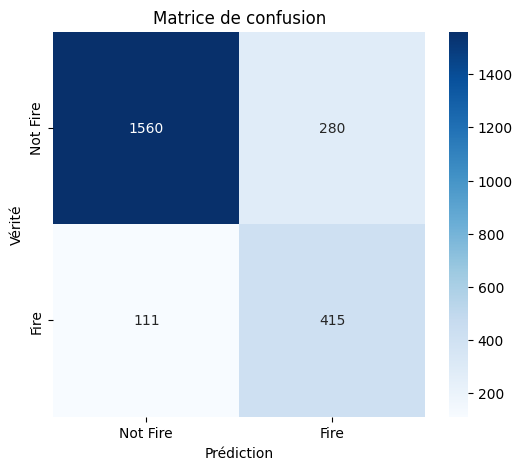

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy : {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall   : {recall:.2f}")
print(f"F1-score : {f1:.2f}")
conf_matrix = confusion_matrix(y_test, y_pred)

# Labels pour les classes
labels = ['Not Fire', 'Fire']  # adapter si nécessaire

# Affichage heatmap
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Prédiction')
plt.ylabel('Vérité')
plt.title('Matrice de confusion')
plt.show()

## RF:classical

/usr/local/lib/python3.12/dist-packages/pyogrio/geopandas.py:382: UserWarning: More than one layer found in 'data_final.gpkg': 'final_data_final' (default), 'data_final'. Specify layer parameter to avoid this warning.
  result = read_func(


Accuracy : 0.85
Precision: 0.78
Recall   : 0.46
F1-score : 0.58


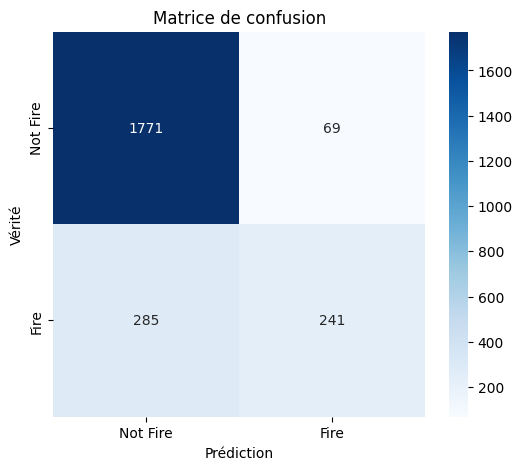

In [ ]:
import pandas as pd
import numpy as np
import geopandas as gpd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# ---------------------------
# DECISION TREE ID3
# ---------------------------
class TreeNode:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

def entropy(y):
    probs = y.value_counts(normalize=True)
    return -sum(p*np.log2(p) for p in probs if p > 0)

def best_split(X, y, features_subset):
    best_gain = -1
    best_feat, best_thresh = None, None
    base_entropy = entropy(y)

    for feat in features_subset:
        values = X[feat].values
        if len(np.unique(values)) == 1:
            continue

        sorted_vals = np.unique(values)
        thresholds = (sorted_vals[:-1] + sorted_vals[1:]) / 2

        for thresh in thresholds:
            left_idx = values <= thresh
            right_idx = values > thresh
            if left_idx.sum() == 0 or right_idx.sum() == 0:
                continue

            left_entropy = entropy(y[left_idx])
            right_entropy = entropy(y[right_idx])

            gain = base_entropy - (
                len(y[left_idx]) / len(y) * left_entropy
                + len(y[right_idx]) / len(y) * right_entropy
            )

            if gain > best_gain:
                best_gain = gain
                best_feat = feat
                best_thresh = thresh

    return best_feat, best_thresh, best_gain

def build_tree(X, y, depth=0, max_depth=5, feature_subset=None):
    if len(y.unique()) == 1:
        return TreeNode(value=y.iloc[0])
    if depth >= max_depth or len(X) == 0:
        return TreeNode(value=y.mode()[0])

    feat, thresh, gain = best_split(X, y, feature_subset)
    if gain == -1:
        return TreeNode(value=y.mode()[0])

    left_idx = X[feat] <= thresh
    right_idx = X[feat] > thresh

    left = build_tree(X[left_idx], y[left_idx], depth+1, max_depth, feature_subset)
    right = build_tree(X[right_idx], y[right_idx], depth+1, max_depth, feature_subset)

    return TreeNode(feature=feat, threshold=thresh, left=left, right=right)

def predict_tree(node, x):
    while node.value is None:
        if x[node.feature] <= node.threshold:
            node = node.left
        else:
            node = node.right
    return node.value

# ---------------------------
# RANDOM FOREST FROM SCRATCH
# ---------------------------
class RandomForestScratch:
    def __init__(self, n_trees=30, max_depth=30, sample_ratio=1):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.sample_ratio = sample_ratio
        self.trees = []

    def bootstrap_sample(self, X, y):
        n_samples = len(X)
        indices = np.random.choice(n_samples, size=n_samples, replace=True)
        return X.iloc[indices], y.iloc[indices]


    def fit(self, X, y):
        n_features = X.shape[1]
        k = int(np.sqrt(n_features))  # √p features

        for _ in range(self.n_trees):
            X_b, y_b = self.bootstrap_sample(X, y)
            features_subset = random.sample(list(X.columns), k)
            tree = build_tree(
                X_b[features_subset],
                y_b,
                depth=0,
                max_depth=self.max_depth,
                feature_subset=features_subset
            )
            self.trees.append((tree, features_subset))

    def predict_one(self, x):
        votes = [predict_tree(tree, x[feats]) for tree, feats in self.trees]
        return max(set(votes), key=votes.count)

    def predict(self, X):
        return X.apply(lambda row: self.predict_one(row), axis=1)

# ---------------------------
# CHARGER LES DONNEES
# ---------------------------
gdf = gpd.read_file("/content/drive/MyDrive/training_fire/Decision Tree/data_final.gpkg")
df = gdf.drop(columns="geometry")
df['fire'] = df['fire'].astype(int)

# ---------------------------
# One-hot encode GRIDCODE
# ---------------------------
df = pd.get_dummies(df, columns=['GRIDCODE'], drop_first=False)

# Split features and target
X = df.drop(columns=['fire'])
y = df['fire']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# ---------------------------
# ENTRAINER LA RANDOM FOREST
# ---------------------------
rf = RandomForestScratch(n_trees=30, max_depth=20)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# ---------------------------
# METRICS
# ---------------------------
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy : {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall   : {recall:.2f}")
print(f"F1-score : {f1:.2f}")
conf_matrix = confusion_matrix(y_test, y_pred)

# Labels pour les classes
labels = ['Not Fire', 'Fire']  # adapter si nécessaire

# Affichage heatmap
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Prédiction')
plt.ylabel('Vérité')
plt.title('Matrice de confusion')
plt.show()
